# Single File Pitch Distribution

This notebook is for experimenting with the the pitch distribution creation and peak detection algorithms and in turn accurately identifying the pitch space of the recording. It works for a single recording at a time.

# 1. Initialization

In [1]:
# Set your token here from https://dunya.compmusic.upf.edu/user/profile/
# This is a random token
token = 'j9fh831536f7f98hp18b3d148klbc2by4k21fx7'

In [2]:
import os 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from compmusic.dunya import docserver as ds
from compmusic import dunya as dn
from external_utilities.predominantmelodymakam import PredominantMelodyMakam
from external_utilities.pitchdistribution import PitchDistribution
from external_utilities.converter import Converter

from compmusic import dunya
dn.set_token(token)

%matplotlib inline
CENTS_IN_OCTAVE=1200
KOMAS_IN_OCTAVE = 53

KOMA_CENT = CENTS_IN_OCTAVE / KOMAS_IN_OCTAVE

In [3]:
MBID_List = [ 
        # Hüseyni
        "75a68ff2-7fe0-4012-afbe-f4de3b8a9a7d", # Baygın Suların          0
        #"a8ff9420-e55f-4af7-9089-3fe29686bc54",# Sarı Gelin 
        "cbcf2d1c-8371-4a57-8893-a1958ed001d3", # Demirciler Demir        1
        "f0e215c0-49f8-4962-8263-590dfff02a31",  # Egin Havası            2
        "0eac190d-13c4-442f-bb13-cf734d3cbe88", # Senden Bilirim          3
        # Saba
        "a49bf764-e19a-4c5f-bd74-07450affa35a", # Cümle Hüccac            4
        "d35e07f4-fbf5-4efb-8a36-721565fa8044", # Süzdükçe Güzel          5
        "e05b2a9f-a129-4847-99ca-562628b97bc1", # Saba Peşrev             6
        "a80b0276-f769-433c-8944-d316848409c5", # Bir Esmere Gönül        7
        # Hüzzam
        "e2e5febb-1ad2-4478-adf6-47e4ee534b16", # Yine Kalbim             8
        "220a57b5-3e8a-4a22-93ed-e7400e6844c4", # Şu Göğsüm               9
        "2c2b51b3-150b-4693-9383-9c467cbbdadd", # Sormadın Halimi        10
        # Rast
        "1701ceba-bd5a-477e-b883-5dacac67da43", # Nihansın Dideden Ey    11
        "48fb37f4-0db9-4bf9-8051-51640bbcf6f1", # Bais-i Berbadım        12 
        "26da8cac-5757-4494-a214-25ad564fc292",  # Rast Zeybek           13
        "0321f83e-bee5-4009-983b-1b4fe3c89f23" # Yüzüdür Cihanı          14       
        ]

In [4]:
# Selecting a recording from the MBID list
n = 10
MBID = MBID_List[n]

In [5]:
if n <= 3:
    makam = "Hüseyni"
elif n >= 4 and n <=7:
    makam = "Saba"
elif n >= 8 and n <=10:
    makam = "Hüzzam"
else:
    makam = "Rast"

In [6]:
dataDir0 = os.path.join('..', 'Oguz', 'data','recordings') # Directory of the recordings
dataDir1 = os.path.join('..', 'Oguz', 'data','pitchTracks','correct_pitchTracks') # directory of the pitch tracks

In [7]:
hopSize = 441 

In [8]:
def compute_pitch(filename):
    
    extractor = PredominantMelodyMakam(hopSize,filter_pitch=True)
    results = extractor.run(filename)
    
    timeStep = extractor.get_settings()['hopSize'] / extractor.get_settings()['sampleRate']
              
    pitch = results['settings']  # collapse the keys in settings
    pitch['pitch'] = results['pitch']
    pitch['timeStep'] = timeStep
    
    return pitch

In [9]:
pitchTrack = dict() # Dictionary for the pitch tracks
pitchSeriesHz = dict() # Dictionary for the pitch Series

In [10]:
def truncate(x,y):
    return int(x*(10)**y) / 10**y   

# 2. Pitch Track

**The cell below**,

puts the pitch track:

1. as a 1D numpy array in **pitch_serie_Hz**, (which is necessary for the pitch distribution)
2. at the **pitchSeriesHz** = { 'ID' : pitchSeriesHz }
3. at the **pitchTrack** = { 'ID' : { time : pitch}  }


In [11]:
# The dictionary containing the tonic information of all the 70 recordings, taken from subset_annotations.json
with open('metaData/MBID_tonic.json', "r",encoding='utf-8') as readf2:
    tonicDict = json.load(readf2)

In [12]:
mp3_filename = os.path.join(dataDir0, '{}.mp3'.format(MBID))
pitchFile = os.path.join(dataDir1, '{}.txt'.format(MBID))

tonic_hz = tonicDict[MBID]

pitchTrack[MBID] = {'Hz': dict(), 'cents': dict()} 

# If pitch file exists, read it, if not run extractor and create the pitch file
if not os.path.exists(pitchFile):

    pitch = compute_pitch(mp3_filename) # Time / Pitch / Salience 

    pitch_serie_Hz = [] # Pitch Track List

    with open(pitchFile, 'w') as fp:
        for p_triplet in pitch['pitch']:

            # p is for hz, c is for cents
            if not p_triplet[1]:
                p = 'S'   # put an S for Silent
                c = 'S'
            else:
                p = truncate(p_triplet[1],2)
                # convert it then truncate 
                c = truncate(Converter.hz_to_cent(p_triplet[1],tonic_hz),2)

            # p_triplet is for the .pitch file 
            fp.write(str(p_triplet[0]) + '\t' + str(p_triplet[1] ) + '\n') 

            pitch_serie_Hz.append(p_triplet[1]) 

            pitchTrack[MBID]['Hz'][p_triplet[0]] = p # Add the time key and the pitch to the dict
            pitchTrack[MBID]['cents'][p_triplet[0]] = c # Add the time key and the cent to the dict

    pitch_serie_Hz = np.array(pitch_serie_Hz)

else:
    print('Loading Existing File')
    
    pitchData = np.loadtxt(pitchFile)
    timeStamps = pitchData[:,0]
    pitch_serie_Hz = pitchData[:,1]

    for p_duo in pitchData:

        if not p_duo[1]:
            p = 'S'
            c = 'S'
        else:
            p = truncate(p_duo[1],2)
            c = truncate(Converter.hz_to_cent(p_duo[1],tonic_hz),2)

        pitchTrack[MBID]['Hz'][p_duo[0]] = p # Add the time key and the pitch 
        pitchTrack[MBID]['cents'][p_duo[0]] = c # Add the time key and the cent 

pitchSeriesHz[MBID] = pitch_serie_Hz # Record the pitch series array in the dictionary

Loading Existing File


# 3. Pitch Distribution Calculation

This section calculates the pitch distribution for various step sizes and kernel widths.

**pitchDistrib = {  'step size' : {  'kernel width': PitchDistribution()   }    }**

In [13]:
step_size = ['2.5','5']
kernel_width = ['2.5','5','7.5','10'] 

In [14]:
pitchDistrib = {}

for step in step_size:    
    pitchDistrib[step]= {}
    
    for kernel in kernel_width:
        
        # Calculate the pitch distribution
        pitchDistrib[step][kernel] = PitchDistribution.from_hz_pitch(pitchSeriesHz[MBID],\
                                                                     tonicDict[MBID], float(kernel),float(step))                  

# 4. Peak Detection with peakLocationDetection()

This section find the peaks of the Pitch Distribution.

**peakLocations = { 'step size' : {  'kernel width': [ peak locations    ]   }    }**

**cents = {  'step size' : {  'kernel width': [   cents    ]   }    }**

In [15]:
# Function definition for automatic scale-interval detection from pitch distribution
def peakLocationDetection(pcd,tresh,ws):
    '''A simple peak detection implementation for demonstration purposes
    Thresholds are manually set for this demo
    '''
    windowSize = ws  # should be odd
    midPointIndex = int(windowSize / 2)
    threshold = np.max(pcd) * tresh
    peakIndexes = []
    for index in range(len(pcd)-windowSize):
        frame = pcd[index:index+windowSize]
        if np.argmax(frame) == midPointIndex and np.max(frame) > threshold:
            peakIndexes.append(index + midPointIndex)
    return peakIndexes

In [16]:
def komaValidator(lst,bound,iterations):
    """
    This function takes a list in cents, a lower bound in cents for identifying two different 
    perdeler, and the number of iterations to be performed to return a new list in cents, that
    are seperated by at least the bound (1 Hc preferably). It keeps the larger of the two perdeler.    
    """
    assert bound >= 22.0, 'The lower bound must be greater than 22 cents!'
    
    new_lst = lst.copy()
    
    for a in range(iterations):
        
        delta = []

        for i in range(len(new_lst)-1):
            delta.append(new_lst[i+1]-new_lst[i])

        for j in range(len(delta)-1):
            if delta[j] < bound:                
                new_lst.remove( min(new_lst[j],new_lst[j+1])) # discard the smallest
                break # exit the inner for loop only
                
    return new_lst        

In [17]:
def shift_to_tonic(lst):
    """
    This function takes a list of a pitch space in cents and returns how much the list is shifted from the tonic,
    with the cents list centered around the tonic.
    """    
    dist = 0
    nlst = lst.copy()
    
    # if 0.0 is in the list exit code        
    if not (0.0 in nlst):
        
        neg = []
        pos = []
            
        for l in nlst:           
            if l < 0:
                neg.append(l)
            elif l> 0:
                pos.append(l)
                        
        if not neg:
            
            dist = min(pos)
            nlst = [l - dist  for l in nlst]
                        
        else:
            m1 = max(neg)
            m2 = min(pos)

            if abs(m1) > m2:
                dist = m2
                nlst = [l - dist for l in nlst]
            else:
                dist = m1
                nlst = [l - dist for l in nlst]
        
        
    return nlst,dist               

In [18]:
treshold = 0.04 #threshold for peak detection
windowSize = 11 #window size for peak detection

In [19]:
peakLocations = {}

cents = {}
centsKoma = dict() # koma validated cents
centsTonicShift = {}

In [21]:
cents['threshold'] = treshold

for step in step_size:

    peakLocations[step] = {}
    cents[step] = {}
    centsKoma[step] = {}
    centsTonicShift[step] = {}
    
    
    for kernel in kernel_width:
        
        # Find the peaks with peakLoc()
        peakLocations[step][kernel] = list(np.array(peakLocationDetection(pitchDistrib[step][kernel].vals,treshold,windowSize)))
        # the peaks in cents
        cents[step][kernel] = list(pitchDistrib[step][kernel].bins[peakLocations[step][kernel]])
        # koma validate the peaks
        centsKoma[step][kernel] = komaValidator(cents[step][kernel],KOMA_CENT,25)
        # center the distribution around the calculated tonic
        shifted,distance = shift_to_tonic(centsKoma[step][kernel])
        centsTonicShift[step][kernel] = {'cents': shifted, 'distance': distance }   

In [22]:
print('Number of initial cents returned for step size and kernel combinations: \n')
for step in step_size:    
    for kernel in kernel_width:
        print("Step Size: {}, Kernel Width: {}, Threshold: {}, Number of Cents: {}".format(step,kernel,cents['threshold'],len(cents[step][kernel])))

Number of initial cents returned for step size and kernel combinations: 

Step Size: 2.5, Kernel Width: 2.5, Threshold: 0.04, Number of Cents: 36
Step Size: 2.5, Kernel Width: 5, Threshold: 0.04, Number of Cents: 27
Step Size: 2.5, Kernel Width: 7.5, Threshold: 0.04, Number of Cents: 20
Step Size: 2.5, Kernel Width: 10, Threshold: 0.04, Number of Cents: 16
Step Size: 5, Kernel Width: 2.5, Threshold: 0.04, Number of Cents: 22
Step Size: 5, Kernel Width: 5, Threshold: 0.04, Number of Cents: 18
Step Size: 5, Kernel Width: 7.5, Threshold: 0.04, Number of Cents: 16
Step Size: 5, Kernel Width: 10, Threshold: 0.04, Number of Cents: 15


# 5. Pitch Distribution Plots 

This section plots all the step size and kernel width combinations for:

1. Returned peaks from pld()
2. Koma Validated peaks
3. Shifted distribution and koma validated peaks so that the tonic is at 0.0

In [23]:
with open('metaData/MakamInformation.json', "r",encoding='utf-8') as readf3:
    MakamInfo = json.load(readf3)
    
AEU = MakamInfo[makam]['cents'] # Locations of the perdeler according to AEU

### 5.1 Pitch Distribution Shifting

This cell is for shifting the Pitch Distribution so that the 0.0 cents is included in the pitch space.

In [24]:
pitchDistrib_binsShifted = {} # all the bins are shifted 

for step in step_size:
    pitchDistrib_binsShifted[step] = {}
    for kernel in kernel_width:
        
        pitchDistrib_binsShifted[step][kernel] = [i-centsTonicShift[step][kernel]['distance'] for i in pitchDistrib[step][kernel].bins]    

### 5.2) Pitch Space Correction

This part is for half-automatic pitch space correction. You can **remove and add certains manually** or you can **specify a cent interval** and add the most prominent cent in that interval automatically.

Note: Be sure that the boundaries are **increasing**

In [25]:
boundaries = []
new_cents = []

In [26]:
ss = '5'
kw = '5'

for i in range(int(len(boundaries)/2)):
    
    # find the interval
    b0 = boundaries[2*i]
    b1 = boundaries[2*i+1]
    
    bins = pitchDistrib_binsShifted[ss][kw]
    
    #find the indexes of the boundaries
    i0 = bins.index(b0)
    i1 = bins.index(b1)
    
    interval = range(i0,i1)
    
    # the values in the interval
    A = pitchDistrib[ss][kw].vals[interval]
    
    # use peak detection on the interval
    small_peak_locs = list(peakLocationDetection(A, 0.05 ,3))
    
    # find the index in the interval
    ind = np.where(A == max(A[small_peak_locs]))[0][0]
    
    # find the corresponding cent
    cent = bins[i0+ind]
    new_cents.append(cent)

print(new_cents)

[]


### 5.3) Koma Validated, Shifted, Corrected Plots

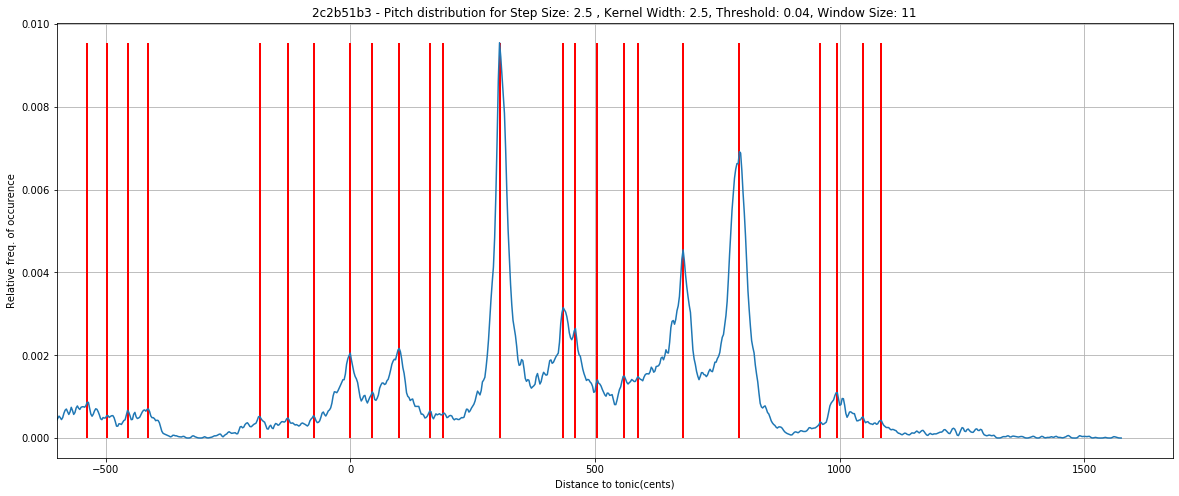

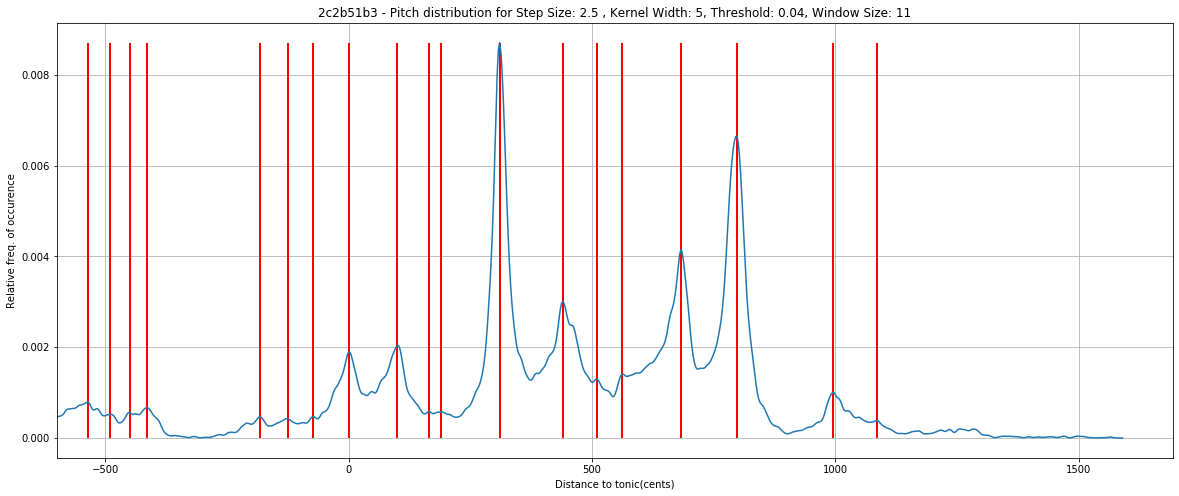

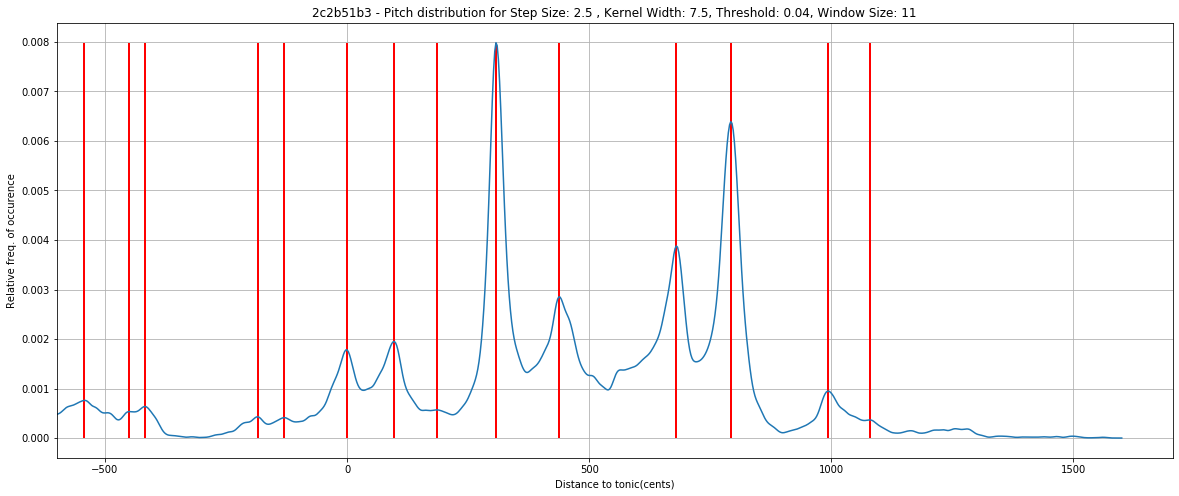

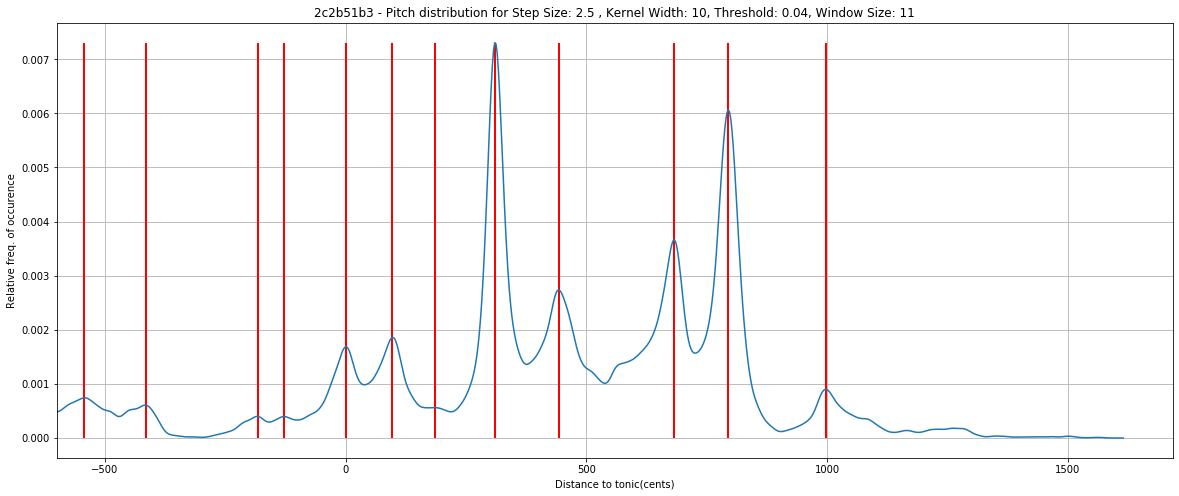

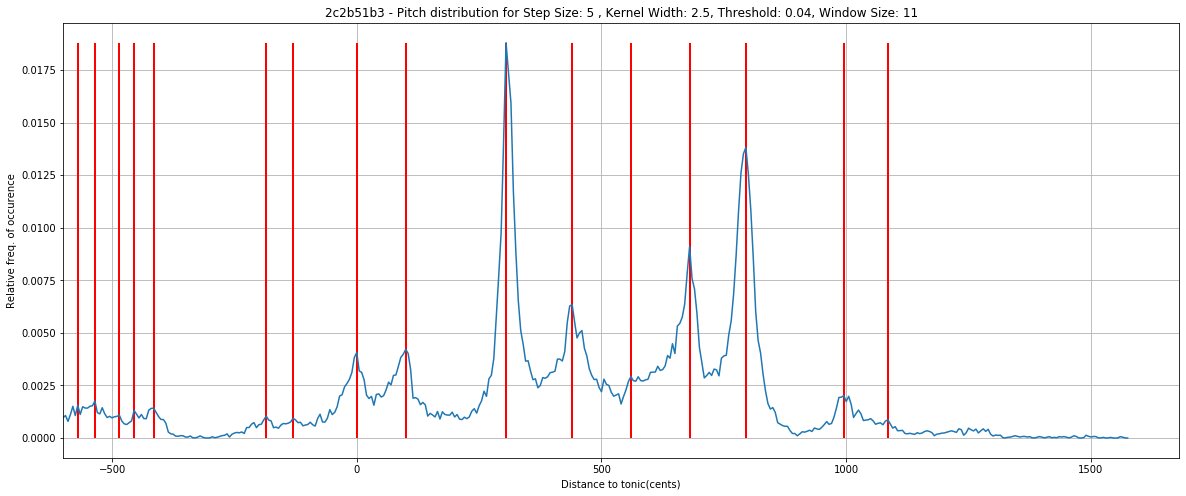

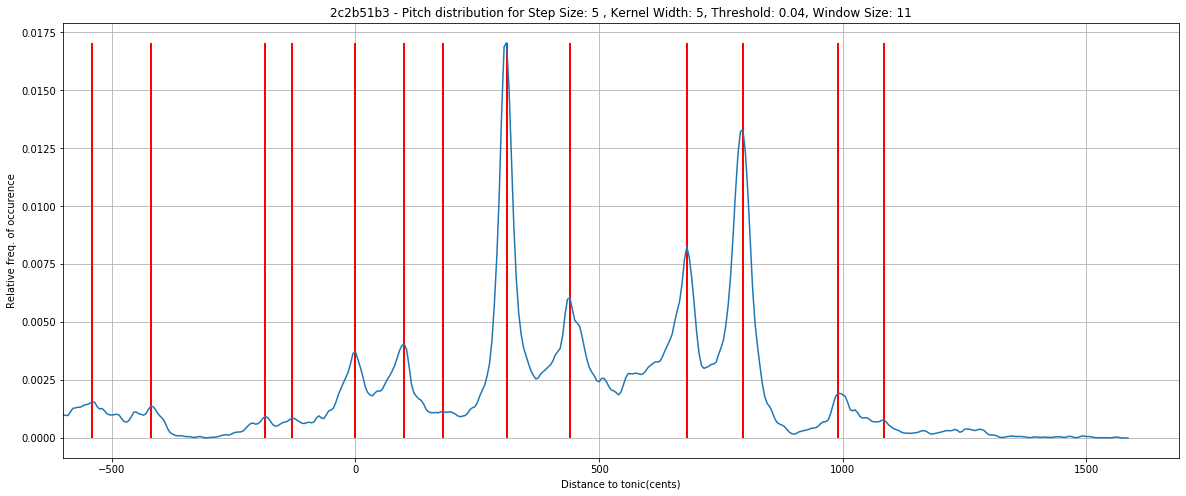

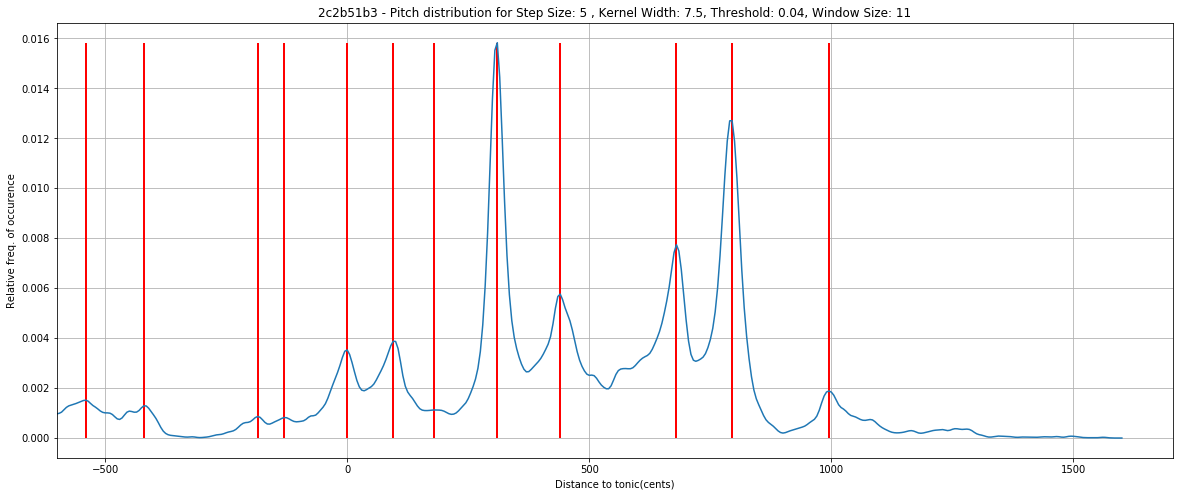

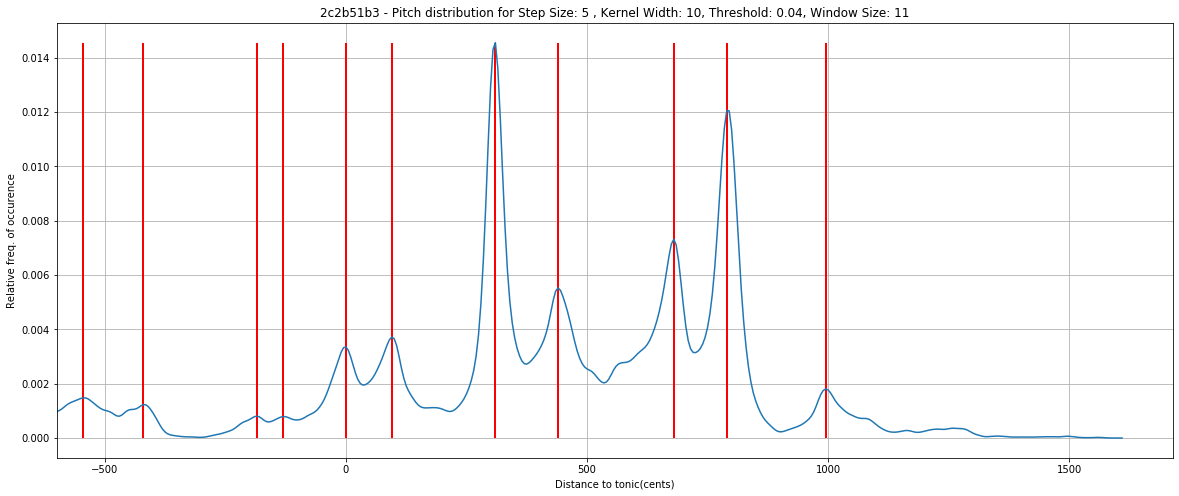

In [27]:
for step in step_size:
    for kernel in kernel_width: 
        
        plt.figure(figsize=(20, 8))    
        plt.plot(pitchDistrib_binsShifted[step][kernel], pitchDistrib[step][kernel].vals)    
        
        # to display the the pitch space
        plt.vlines(centsTonicShift[step][kernel]['cents'], 0, max(pitchDistrib[step][kernel].vals), color='r', lw=2)
        
        # to display the AEU locations of perdeler
        #plt.vlines(AEU, 0, max(pitchDistrib[step][kernel].vals), color='g', lw=2)
        
        # to display the outputs of the Local Search
        #plt.vlines(new_cents, 0, max(pitchDistrib[step][kernel].vals), color='m', lw=2) 
                            
        lower = min(pitchDistrib[step][kernel].bins) -100
        higher = max(pitchDistrib[step][kernel].bins) + 100
        
        plt.title('{} - Pitch distribution for Step Size: {} , Kernel Width: {}, Threshold: {}, Window Size: {}'\
                  .format(MBID.split('-')[0],step,kernel,cents['threshold'],windowSize))
        plt.grid()
        plt.xlim([lower, higher])
        plt.ylabel('Relative freq. of occurence')
        plt.xlabel('Distance to tonic(cents)')

### 5.4) Dividing the Distribution

With this cell, you can use different parameters for pitch distribution calculation for the lower and higher octaves and plot the result

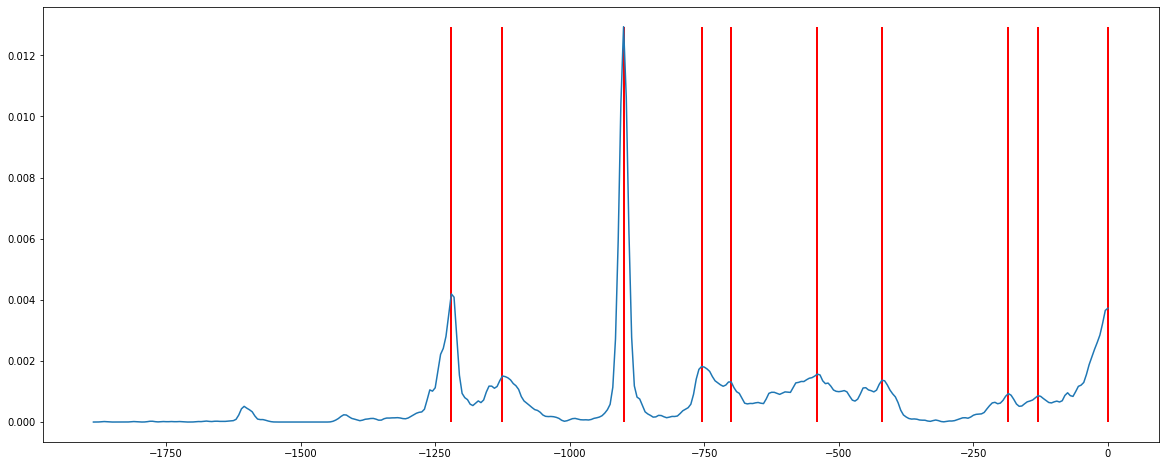

In [28]:
step = '5'
kernel = '5'

lower_cents = [i for i in centsTonicShift[step][kernel]['cents'] if i<=0 ]
higher_cents = [i for i in centsTonicShift[step][kernel]['cents'] if i>0 ]

tonic_index = pitchDistrib_binsShifted[step][kernel].index(0.0)

lower_bins = pitchDistrib_binsShifted[step][kernel][0:tonic_index+1]
lower_bins_values = pitchDistrib[step][kernel].vals[0:tonic_index+1]

higher_bins = pitchDistrib_binsShifted[step][kernel][tonic_index+1:]
higher_bins_values = pitchDistrib[step][kernel].vals[tonic_index+1:]


plt.figure(figsize=(20, 8))
plt.plot(lower_bins,lower_bins_values)
plt.vlines(lower_cents, 0, max(lower_bins_values), color='r', lw=2)

### 5.4)  Single Distribution Plotting

This part is for plotting a single distribution.

Text(0.5, 0, 'Distance to tonic(cents)')

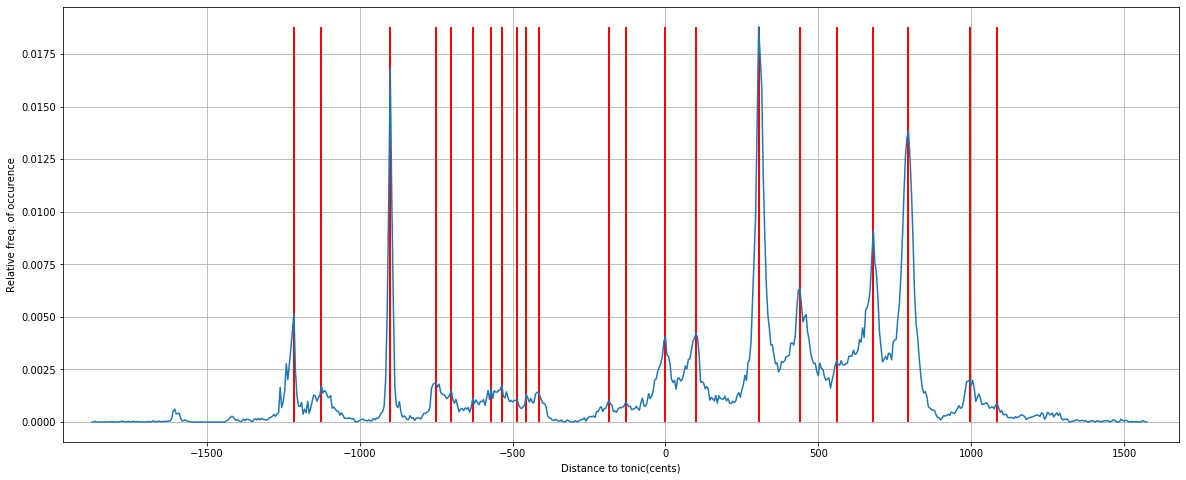

In [29]:
step = '5'
kernel = '2.5'

plt.figure(figsize=(20, 8))    
plt.plot(pitchDistrib_binsShifted[step][kernel], pitchDistrib[step][kernel].vals)

plt.vlines(centsTonicShift[step][kernel]['cents'], 0, max(pitchDistrib[step][kernel].vals), color='r', lw=2)

lower = min(pitchDistrib[step][kernel].bins) -100
higher = max(pitchDistrib[step][kernel].bins) + 100

plt.grid()
plt.xlim([lower, higher])
plt.ylabel('Relative freq. of occurence')
plt.xlabel('Distance to tonic(cents)')